<a href="https://colab.research.google.com/github/JavierPachas/pytorch/blob/main/diffuser_model_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A diffuser model with PyTorch

In [ ]:
!pip install kaleido
!pip uvicorn
!pip install python-multipart
!pip install fastapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
ERROR: unknown command "uvicorn"
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 9.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are i

In [ ]:
!pip install torchmultimodal-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 82.6 MB/s eta 0:00:00
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=66dfe287f8cd84c8157d3d3350e4a02cfd8ecc28529763e882df6d6618cdb249
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath
  Attempting uninstall: attrs
    Found existing installation: attrs 23.2.0
    Uninstalling attrs-23.2.0:
      

In [ ]:
import torch
import torchvision
import torchvision.transforms.functional as F

In [ ]:
from torch import nn
from tqdm import tqdm
from torchmultimodal.diffusion_labs.modules.adapters.cfguidance import CFGuidance
from torchmultimodal.diffusion_labs.modules.losses.diffusion_hybrid_loss import DiffusionHybridLoss
from torchmultimodal.diffusion_labs.samplers.ddpm import DDPModule
from torchmultimodal.diffusion_labs.predictors.noise_predictor import NoisePredictor
from torchmultimodal.diffusion_labs.schedules.discrete_gaussian_schedule import linear_beta_schedule, DiscreteGaussianSchedule
from torchmultimodal.diffusion_labs.transforms.diffusion_transform import RandomDiffusionSteps
from torchmultimodal.diffusion_labs.utils.common import DiffusionOutput

# Schedule

In [ ]:
#Define diffusion schedule
schedule = DiscreteGaussianSchedule(linear_beta_schedule(1000))

#Predictor

In [ ]:
#Define prediction target

predictor = NoisePredictor(schedule, lambda x: torch.clamp(x, -1, 1))

#U-Net

In [ ]:
#for a larger model using GPU
#from torchmultimodal.diffusion_labs.models.adm_unet.adm import adm_unet

#unet = adm_unet(
#    time_embed_dim = 32,
#    embed_dim = 32,
#    embed_name = 'context',
#    predict_variance_value = True,
#    image_channels = 1
#)

In [ ]:
class DownBlock(nn.Module):
  def __init__(self, in_channels, out_channels, cond_channels):
    super().__init__()
    self.block = nn.Sequential(
        nn.Conv2d(in_channels + cond_channels, out_channels, kernel_size =3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size =3, padding = 1),
        nn.ReLU(),
    )
    self.pooling = nn.AvgPool2d(kernel_size=2, stride = 2)

  def forward(self, x, c):
    _, _, w, h = x.size()
    c = c.expand(-1, -1, w, h)
    x = self.block(torch.cat([x, c],1))
    x_small = self.pooling(x)
    return x, x_small

class UpBlock(nn.Module):
  def __init__(self, inp, out):
    super().__init__()
    self.block = nn.Sequential(
        nn.Conv2d(2*inp, out, kernel_size =3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(out, out, kernel_size =3, padding = 1),
        nn.ReLU(),
    )
    self.upsample = nn.Upsample(scale_factor= 2)

  def forward(self, x, x_small):
    x_big = self.upsample(x_small)
    x = torch.cat((x_big, x), dim = 1)
    x = self.block(x)
    return x

class UNet(nn.Module):
  def __init__(self, time_size = 32, digit_size = 32, steps = 1000):
    super().__init__()
    cond_size = time_size + digit_size
    self.conv = nn.Conv2d(1, 128, kernel_size=3, padding = 1)
    self.down = nn.ModuleList([DownBlock(128, 256, cond_size), DownBlock(256, 512, cond_size)])
    self.bottleneck =DownBlock(512, 512, cond_size)
    self.up = nn.ModuleList([UpBlock(512, 256), UpBlock(256, 128)])

    self.time_projection = nn.Embedding(steps, time_size)
    self.prediction = nn.Conv2d(128, 1, kernel_size = 3, padding = 1)
    self.variance = nn.Conv2d(128, 1, kernel_size = 3, padding = 1)

  def forward(self, x, t, conditional_inputs):
    b, c, h, w = x.shape
    timestep = self.time_projection(t).view(b, -1, 1, 1)
    condition = conditional_inputs["context"].view(b, -1, 1, 1)
    condition = torch.cat([timestep, condition], dim =1)

    x = self.conv(x)
    outs = []
    for block in self.down:
      out, x = block(x, condition)
      outs.append(out)
    x, _ = self.bottleneck(x, condition)
    for block in self.up:
      x = block(outs.pop(), x)

    v = self.variance(x)
    p = self.prediction(x)
    return DiffusionOutput(p, v)


#Diffusion Model

In [ ]:
unet = UNet(time_size = 32, digit_size = 32)
unet = CFGuidance(unet, {'Context':32}, guidance = 2.0)

In [ ]:
#define evaluation
eval_steps = torch.linspace(0,999, 250, dtype = torch.long)
model = DDPModule(unet, schedule, predictor, eval_steps)

In [ ]:
#Conditional embedding
encoder =nn.Embedding(10, 32)

#Data

In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor, Lambda

In [ ]:
#transform data and use RandomDiffusionSteps to sample random noise
diffusion_transform = RandomDiffusionSteps(schedule, batched = False)

transform = Compose([Resize(32),
                      ToTensor(),
                      Lambda(lambda x: 2*x -1),
                      Lambda(lambda x: diffusion_transform({'x':x}))])

In [ ]:
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

train_dataset = FashionMNIST('fashion_mnist', train = True, download = True, transform = transform)
train_dataloader = DataLoader(train_dataset, batch_size = 192, shuffle = True, num_workers = 2, pin_memory = True)

#Train

In [ ]:
epochs = 10

device = torch.device('cuda' if torch.cuda.is_available else 'cpu') #'cuda:3'
encoder.to(device)
model.to(device)

optimizer = torch.optim.AdamW(
    [{'params': encoder.parameters()}, {'params': model.parameters()}], lr = 0.0001
)
h_loss = DiffusionHybridLoss(schedule)

encoder.train()
model.train()

for e in range(epochs):
  for sample in (pbar :=tqdm(train_dataloader)):
    x, c = sample
    x0, xt, noise, t, c = x['x'].to(device), x['xt'].to(device), x['noise'].to(device), x['t'].to(device), c.to(device)
    optimizer.zero_grad()

    #computing loss
    embedding = encoder(c)
    out = model(xt, t, {'context': embedding})
    loss = h_loss(out.prediction, noise, out.mean, out.log_variance, x0, xt, t)

    loss.backward()
    optimizer.step()

    pbar.set_description(f'{e+1} | Loss: {loss.item()}')


1 | Loss: 0.057172879576683044: 100%|██████████| 313/313 [02:42<00:00,  1.92it/s]
2 | Loss: 0.063269704580307: 100%|██████████| 313/313 [02:45<00:00,  1.89it/s]
3 | Loss: 0.06706809997558594: 100%|██████████| 313/313 [02:51<00:00,  1.83it/s]
4 | Loss: 0.03851539269089699: 100%|██████████| 313/313 [02:51<00:00,  1.83it/s]
5 | Loss: 0.03582620620727539: 100%|██████████| 313/313 [02:45<00:00,  1.89it/s]
6 | Loss: 0.048224471509456635: 100%|██████████| 313/313 [02:41<00:00,  1.93it/s]
7 | Loss: 0.03423798084259033: 100%|██████████| 313/313 [02:42<00:00,  1.93it/s]
8 | Loss: 0.03064773976802826: 100%|██████████| 313/313 [02:42<00:00,  1.92it/s]
9 | Loss: 0.0302360188215971: 100%|██████████| 313/313 [02:42<00:00,  1.93it/s]
10 | Loss: 0.038120996206998825: 100%|██████████| 313/313 [02:41<00:00,  1.93it/s]


#Generate

In [ ]:
def fashion_encoder(name, num=1):
  fashion_dict = {'t-shirt':0, 'pants': 1, 'sweater': 2, 'dress': 3, 'coat':4,
                  'sandal': 5, 'shirt': 6, 'sneaker': 7, 'purse': 8, 'boot': 9}
  idx = torch.as_tensor([fashion_dict[name] for _ in range(num)]).to(device)

  encoder.eval()
  with torch.no_grad():
    embed = encoder(idx)
  return embed

  0%|          | 0/250 [00:00<?, ?it/s]

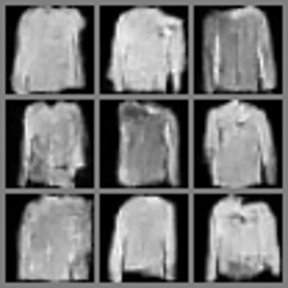

In [ ]:
model.eval()

c = fashion_encoder('shirt',9)
noise = torch.randn(size = (9,1,32,32)).to(device)

with torch.no_grad():
  imgs = model(noise, conditional_inputs = {'context': c})

img_grid = torchvision.utils.make_grid(imgs, 3)
img =  F.to_pil_image((img_grid +1) /2)
img.resize((288, 288))